# Movie Recommendation System using Content-Based Filtering

By: Nadila Agustiani Farhan

## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Load Dataset

Dataset menggunakan data movie yang diambil dari kaggle:

https://www.kaggle.com/datasets/arthurchongg/imdb-top-1000-movies

**Penjelasan setiap fitur dalam data**
- **title :**	Judul film. Bertipe object (teks).
- **director :**	Nama sutradara yang mengarahkan film. Bertipe object.
- **release_year :**	Tahun rilis film, namun masih dalam format string dan perlu dibersihkan.
- **runtime :**	Durasi film, disimpan dalam bentuk teks seperti "142 min".
- **genre :**	Genre film, bisa terdiri dari satu atau lebih genre yang dipisahkan koma.
- **rating :**	Rating film berdasarkan penilaian pengguna (skala 1–10).
- **metascore :**	Skor film dari kritikus (skala 0–100).
- **gross :**	Pendapatan kotor film, dalam format string (contoh: "$28.34M"). Perlu dibersihkan untuk analisis numerik.

In [ ]:
# Membaca dataset dari GitHub
mv_df = pd.read_csv('https://raw.githubusercontent.com/Nadila-agustF/recomendasi/refs/heads/main/imdb_raw.csv')
mv_df.head()


,title,director,release_year,runtime,genre,rating,metascore,gross
0,The Shawshank Redemption,Frank Darabont,(1994),142 min,Drama,9.3,82,$28.34M
1,The Godfather,Francis Ford Coppola,(1972),175 min,"Crime, Drama",9.2,100,$134.97M
2,The Dark Knight,Christopher Nolan,(2008),152 min,"Action, Crime, Drama",9.0,84,$534.86M
3,Schindler's List,Steven Spielberg,(1993),195 min,"Biography, Drama, History",9.0,95,$96.90M
4,12 Angry Men,Sidney Lumet,(1957),96 min,"Crime, Drama",9.0,97,$4.36M


## Exploratory Data Analysis (EDA)

In [ ]:
# Informasi struktur data
mv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1000 non-null   object 
 1   director      1000 non-null   object 
 2   release_year  1000 non-null   object 
 3   runtime       1000 non-null   object 
 4   genre         1000 non-null   object 
 5   rating        1000 non-null   float64
 6   metascore     1000 non-null   int64  
 7   gross         1000 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 62.6+ KB


Note:

Dataset yang digunakan dalam proyek ini terdiri dari 1.000 baris data dan 8 kolom fitur yang merepresentasikan informasi terkait film, seperti judul, sutradara, genre, rating, tahun rilis, durasi, skor Metascore, dan pendapatan kotor. Namun, terdapat beberapa hal yang perlu dibersihkan dalam data, seperti kolom release_year yang masih bertipe objek. Kolom ini perlu diubah menjadi tipe numerik agar dapat dieksplorasi dan dianalisis dengan lebih optimal.

In [ ]:
print("---------------Informasi Dataset-----------------")
mv_df

---------------Informasi Dataset-----------------


,title,director,release_year,runtime,genre,rating,metascore,gross
0,The Shawshank Redemption,Frank Darabont,(1994),142 min,Drama,9.3,82,$28.34M
1,The Godfather,Francis Ford Coppola,(1972),175 min,"Crime, Drama",9.2,100,$134.97M
2,The Dark Knight,Christopher Nolan,(2008),152 min,"Action, Crime, Drama",9.0,84,$534.86M
3,Schindler's List,Steven Spielberg,(1993),195 min,"Biography, Drama, History",9.0,95,$96.90M
4,12 Angry Men,Sidney Lumet,(1957),96 min,"Crime, Drama",9.0,97,$4.36M
...,...,...,...,...,...,...,...,...
995,A Very Long Engagement,Jean-Pierre Jeunet,(2004),133 min,"Drama, Mystery, Romance",7.6,76,$6.17M
996,Shine,Scott Hicks,(1996),105 min,"Biography, Drama, Music",7.6,87,$35.81M
997,Philomena,Stephen Frears,(2013),98 min,"Biography, Comedy, Drama",7.6,77,$37.71M
998,The Invisible Man,James Whale,(1933),71 min,"Horror, Sci-Fi",7.6,87,0


Note:

Terdapat data yang bernilai 0 pada kolom metascore dan gross

In [ ]:
# Menampilkan data yang bernilai 0
mv_df[mv_df['metascore'] == 0]

,title,director,release_year,runtime,genre,rating,metascore,gross
15,Jai Bhim,T.J. Gnanavel,(2021),164 min,"Crime, Drama, Mystery",8.8,0,0
16,777 Charlie,Kiranraj K,(2022),164 min,"Adventure, Comedy, Drama",8.8,0,0
22,Rocketry: The Nambi Effect,Madhavan,(2022),157 min,"Biography, Drama",8.7,0,0
23,Soorarai Pottru,Sudha Kongara,(2020),153 min,"Action, Drama",8.7,0,0
36,Sita Ramam,Hanu Raghavapudi,(2022),163 min,"Action, Drama, Mystery",8.6,0,0
...,...,...,...,...,...,...,...,...
906,Key Largo,John Huston,(1948),100 min,"Action, Crime, Drama",7.7,0,0
908,Confessions,Tetsuya Nakashima,(2010),106 min,"Drama, Thriller",7.7,0,0
909,Dreams,Akira Kurosawa,(1990),119 min,"Drama, Fantasy",7.7,0,$1.96M
924,Zelig,Woody Allen,(1983),79 min,Comedy,7.7,0,$11.80M


Note:

Ternyata terdapat cukup banyak data yang bernilai 0. Untuk memastikan jumlah data bernilai 0, maka gunakan perintah berikut.

In [ ]:
# periksa jumlah data bernilai 0 pada kolom metascore dan gross
print("Jumlah data 0 pada kolom metascore:", (mv_df['metascore'] == 0).sum())
print("Jumlah data 0 pada kolom gross:", (mv_df['gross'] == 0).sum())

Jumlah data 0 pada kolom metascore: 156
Jumlah data 0 pada kolom gross: 0


Note:

Data yang bernilai 0 cukup banyak. Dalam kasus ini, karena fokus sistem rekomendasi berbasis konten ini hanya pada atribut genre dan sutradara sehingga tidak relevan untuk digunakan dalam pemodelan sistem ini, maka kolom metascore dan gross dihapus dari dataset.

In [ ]:
# hapus kolom metascore dan gross
mv_df = mv_df.drop(['metascore', 'gross'], axis=1)
mv_df.head()

,title,director,release_year,runtime,genre,rating
0,The Shawshank Redemption,Frank Darabont,(1994),142 min,Drama,9.3
1,The Godfather,Francis Ford Coppola,(1972),175 min,"Crime, Drama",9.2
2,The Dark Knight,Christopher Nolan,(2008),152 min,"Action, Crime, Drama",9.0
3,Schindler's List,Steven Spielberg,(1993),195 min,"Biography, Drama, History",9.0
4,12 Angry Men,Sidney Lumet,(1957),96 min,"Crime, Drama",9.0


In [ ]:
# Menghapus string dan tanda baca pada kolom release_year
mv_df['release_year'] = mv_df['release_year'].str.replace(r'\D', '', regex=True)

# Mengubah tipe data tahun rilis menjadi numerik
mv_df['release_year'] = mv_df['release_year'].astype(int)
mv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1000 non-null   object 
 1   director      1000 non-null   object 
 2   release_year  1000 non-null   int64  
 3   runtime       1000 non-null   object 
 4   genre         1000 non-null   object 
 5   rating        1000 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB


Note:
Data tahun rilis sudah berhasil diubah ke numerik dan mengandung tahun rilis setiap judul film

In [ ]:
# Statistik deskriptif kolom numerik
mv_df.describe()

,release_year,rating
count,1000.000000,1000.00000
mean,1991.619000,7.96870
std,24.146861,0.27562
min,1920.000000,7.60000
25%,1975.000000,7.80000
50%,1999.000000,7.90000
75%,2011.000000,8.10000
max,2023.000000,9.30000


Note:

Rating film dalam dataset berkisar antara 7.6 hingga 9.3 (dalam skala 1 hingga 10), sedangkan tahun rilis dari judul film yang tersedia dari yang paling lama (1920) hingga terbaru (2023).

In [ ]:
# Cek nilai hilang dan duplikasi
print("Jumlah missing value:", mv_df.isna().sum())
print("Jumlah duplikasi data:", mv_df.duplicated().sum())


Jumlah missing value: title           0
director        0
release_year    0
runtime         0
genre           0
rating          0
dtype: int64
Jumlah duplikasi data: 0


Data tidak memiliki missing value maupun duplikasi data

In [ ]:
# Jumlah nilai unik di setiap kolom
print("Jumlah unique value setiap kolom:")
print(mv_df.nunique())


Jumlah unique value setiap kolom:
title           994
director        560
release_year    102
runtime         142
genre           195
rating           17
dtype: int64


**Note:**

Terdapat 994 judul film yang unik, dengan jumlah 560 sutradara menunjukkan bahwa sebagian besar film disutradarai oleh orang yang berbeda-beda.
Selain itu, terdapat 195 kombinasi genre yang berbeda, yang mengindikasikan bahwa genre merupakan fitur yang cukup variatif dan dapat menjadi informasi penting dalam sistem rekomendasi berbasis konten.


In [ ]:
# Genre unik
print("Genre unik:")
print(mv_df['genre'].unique())


Genre unik:
['Drama' 'Crime, Drama' 'Action, Crime, Drama' 'Biography, Drama, History'
 'Action, Adventure, Drama' 'Animation, Action, Adventure'
 'Action, Adventure, Sci-Fi' 'Drama, Romance' 'Adventure, Western'
 'Crime, Drama, Mystery' 'Adventure, Comedy, Drama'
 'Adventure, Drama, Sci-Fi' 'Biography, Crime, Drama' 'Action, Sci-Fi'
 'Action, Adventure, Fantasy' 'Biography, Drama' 'Action, Drama'
 'Crime, Drama, Fantasy' 'Drama, War' 'Crime, Drama, Thriller'
 'Animation, Adventure, Family' 'Comedy, Drama, Romance'
 'Drama, Family, Fantasy' 'Action, Drama, Mystery'
 'Adventure, Comedy, Sci-Fi' 'Horror, Sci-Fi' 'Drama, Thriller'
 'Drama, Mystery, Sci-Fi' 'Drama, Music' 'Animation, Adventure, Drama'
 'Drama, Romance, War' 'Horror, Mystery, Thriller'
 'Biography, Drama, Music' 'Biography, Comedy, Drama' 'Western'
 'Animation, Drama, War' 'Mystery, Thriller' 'Action, Adventure'
 'Drama, Western' 'Drama, Mystery, War' 'Action, Drama, Thriller'
 'Drama, Horror' 'Drama, Thriller, War' 'Animat

## Visualisasi Data Analysis

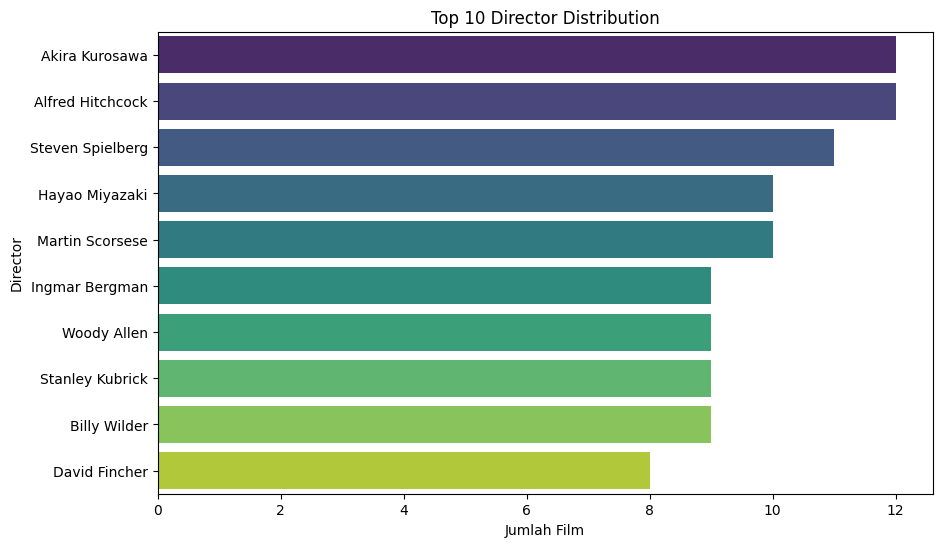

In [ ]:
# Visualisasi top 10 Sutradara film
plt.figure(figsize=(10, 6))
sns.countplot(data=mv_df, y='director', order=mv_df['director'].value_counts().index[:10], palette='viridis')
plt.title('Top 10 Director Distribution')
plt.xlabel('Jumlah Film')
plt.ylabel('Director')
plt.show()


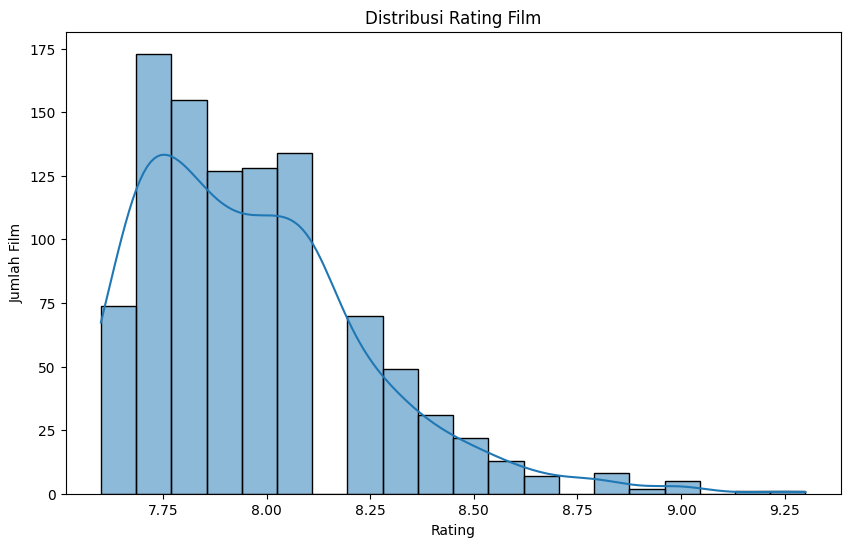

In [ ]:
# Visualisasi Distribusi Rating
plt.figure(figsize=(10, 6))
sns.histplot(data=mv_df, x='rating', bins=20, kde=True, palette='viridis')
plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Jumlah Film')
plt.show()

**Note:**

Grafik di atas menunjukkan distribusi rating film dalam dataset.
- Sebagian besar film memiliki rating antara 7.6 hingga 8.2, yang berarti mayoritas film mendapat penilaian cukup tinggi namun tidak ekstrem.
- Jumlah film paling banyak berada di sekitar rating 7.7–8.0, yang membentuk puncak distribusi (modus).

<ipython-input-151-1604161513>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year_interval_counts.index, y=year_interval_counts.values, palette='coolwarm')


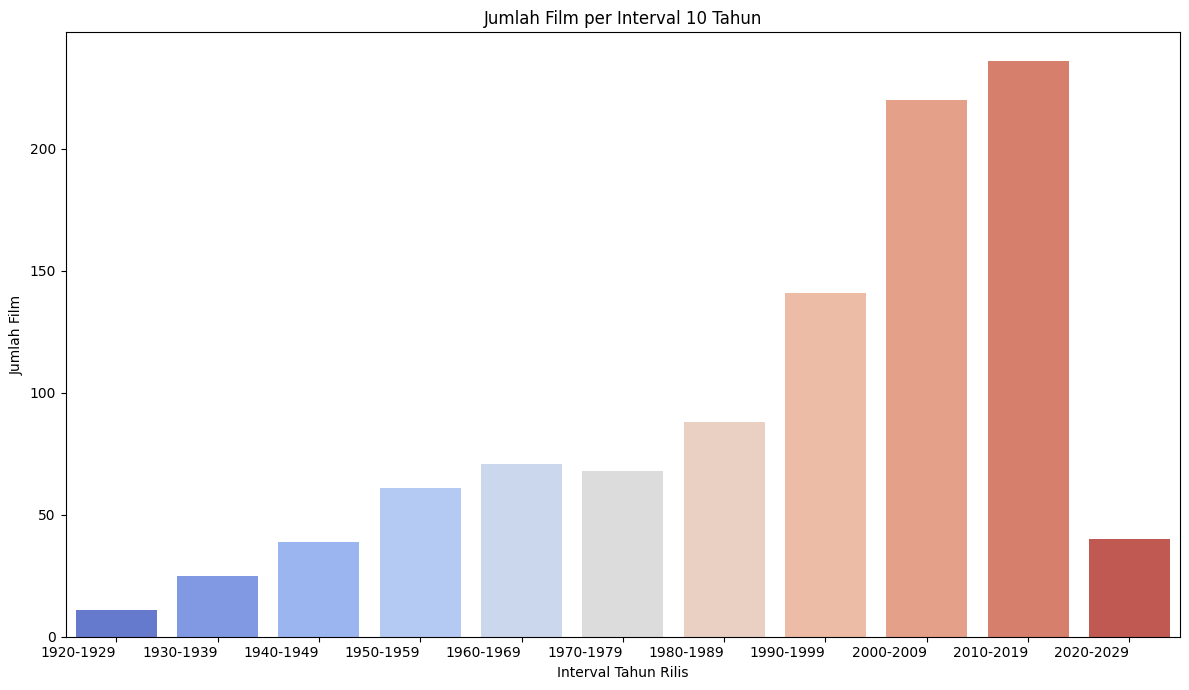

In [ ]:
# Membuat interval tahun dengan selisih 10 tahun
min_year = mv_df['release_year'].min()
max_year = mv_df['release_year'].max()

# Menentukan rentang interval
bins = list(range(min_year, max_year + 11, 10))

# Membuat label untuk interval
labels = [f'{i}-{i+9}' for i in bins[:-1]]

# Membuat kolom baru untuk interval tahun
mv_df['year_interval'] = pd.cut(mv_df['release_year'], bins=bins, labels=labels, right=False)

# Menghitung jumlah film di setiap interval tahun
year_interval_counts = mv_df['year_interval'].value_counts().sort_index()

# Membuat grafik batang
plt.figure(figsize=(12, 7))
sns.barplot(x=year_interval_counts.index, y=year_interval_counts.values, palette='coolwarm')
plt.title('Jumlah Film per Interval 10 Tahun')
plt.xlabel('Interval Tahun Rilis')
plt.ylabel('Jumlah Film')
plt.xticks(ha='right')
plt.tight_layout()
plt.show()

Note:

Jumlah film yang paling banyak rilis antara tahun 2000 hingga 2019

## Feature Engineering untuk Content-Based Filtering

In [ ]:
# Menggabungkan fitur deskriptif menjadi satu kolom teks
mv_df['combined_features'] = mv_df['director'] + ": " + mv_df['genre']
mv_df[['title', 'combined_features']].head()


,title,combined_features
0,The Shawshank Redemption,Frank Darabont: Drama
1,The Godfather,"Francis Ford Coppola: Crime, Drama"
2,The Dark Knight,"Christopher Nolan: Action, Crime, Drama"
3,Schindler's List,"Steven Spielberg: Biography, Drama, History"
4,12 Angry Men,"Sidney Lumet: Crime, Drama"


## TF-IDF Vectorization dan Cosine Similarity

In [ ]:
# Ubah fitur gabungan menjadi vektor numerik
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(mv_df['combined_features'])

# Hitung cosine similarity antar film
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

## Mapping Judul Film ke Index

In [ ]:
# Buat mapping dari judul ke index baris
indices = pd.Series(mv_df.index, index=mv_df['title']).drop_duplicates()

## Fungsi Rekomendasi Film

In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim):
    if title not in indices:
        return f"Judul '{title}' tidak ditemukan dalam dataset."

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]

    result = []
    for i, score in sim_scores:
        result.append((mv_df['title'].iloc[i], round(score, 4)))

    return pd.DataFrame(result, columns=['Title', 'Similarity Score'])

In [ ]:
get_recommendations('The Dark Knight')

,Title,Similarity Score
0,Batman Begins,1.0000
1,The Dark Knight Rises,0.9039
2,Dunkirk,0.8627
3,Memento,0.7886
4,Inception,0.7756
5,Interstellar,0.7394
6,The Prestige,0.7265
7,Mission: Impossible - Fallout,0.4157
8,Vikram Vedha,0.2062
9,Key Largo,0.2033


Dari film "The Godfather", sistem memberikan 10 rekomendasi judul film lain yang dianggap serupa diantaranya berdasarkan dengan nilai metriks similarity nya:

Dari 10 film tersebut dipilih berdasarkan kemiripan konten, terutama dari sisi sutradara dan genre. Beberapa film di atas disutradarai oleh Francis Ford Coppola, yang juga merupakan sutradara dari "The Godfather", serta memiliki genre crime atau drama yang sejalan dengan film input.

## Evaluasi

In [ ]:
def recommend(title, cosine_sim=cosine_sim, df=mv_df):
    if title not in indices:
        return f"Judul '{title}' tidak ditemukan di database."

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # 5 film teratas selain dirinya sendiri
    movie_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[movie_indices]

In [ ]:
# Memeriksa precision dan akurasi conten based filtering
# rekomendasi untuk beberapa contoh film:

def evaluate_recommendation_precision(title, recommended_titles, df=mv_df):
    if not recommended_titles.empty:
        original_movie = df[df['title'] == title].iloc[0]
        original_genre = set(original_movie['genre'].split(','))
        original_director = original_movie['director']

        evaluation_results = {}
        for rec_title in recommended_titles:
            rec_movie = df[df['title'] == rec_title].iloc[0]
            rec_genre = set(rec_movie['genre'].split(','))
            rec_director = rec_movie['director']

            # Hitung kesamaan genre (intersection over union)
            genre_intersection = len(original_genre.intersection(rec_genre))
            genre_union = len(original_genre.union(rec_genre))
            genre_similarity = genre_intersection / genre_union if genre_union > 0 else 0

            # Periksa apakah sutradara sama
            director_match = original_director == rec_director

            evaluation_results[rec_title] = {
                'Genre Asli': original_movie['genre'],
                'Genre Rekomendasi': rec_movie['genre'],
                'Director Asli': original_director,
                'Director Rekomendasi': rec_director,
                'Genre Similarity (IoU)': genre_similarity,
                'Director Match': director_match
            }
        return evaluation_results
    else:
        return {"Pesan": "Tidak ada rekomendasi ditemukan."}

# Contoh evaluasi untuk "The Godfather"
example_title = "The Godfather"
recommended_movies = recommend(example_title)

if isinstance(recommended_movies, pd.Series):
    evaluation = evaluate_recommendation_precision(example_title, recommended_movies)
    print(f"\n--- Evaluasi Rekomendasi untuk '{example_title}' ---")
    for rec_title, metrics in evaluation.items():
        print(f"\nFilm Rekomendasi: {rec_title}")
        for key, value in metrics.items():
            print(f"  {key}: {value}")
else:
    print(recommended_movies) # Output pesan error jika judul tidak ditemukan

# Contoh evaluasi untuk film lain (misal "The Dark Knight")
example_title_2 = "The Dark Knight"
recommended_movies_2 = recommend(example_title_2)

if isinstance(recommended_movies_2, pd.Series):
    evaluation_2 = evaluate_recommendation_precision(example_title_2, recommended_movies_2)
    print(f"\n--- Evaluasi Rekomendasi untuk '{example_title_2}' ---")
    for rec_title, metrics in evaluation_2.items():
        print(f"\nFilm Rekomendasi: {rec_title}")
        for key, value in metrics.items():
            print(f"  {key}: {value}")
else:
    print(recommended_movies_2)


--- Evaluasi Rekomendasi untuk 'The Godfather' ---

Film Rekomendasi: The Godfather Part II
  Genre Asli: Crime, Drama
  Genre Rekomendasi: Crime, Drama
  Director Asli: Francis Ford Coppola
  Director Rekomendasi: Francis Ford Coppola
  Genre Similarity (IoU): 1.0
  Director Match: True

Film Rekomendasi: The Conversation
  Genre Asli: Crime, Drama
  Genre Rekomendasi: Drama, Mystery, Thriller
  Director Asli: Francis Ford Coppola
  Director Rekomendasi: Francis Ford Coppola
  Genre Similarity (IoU): 0.0
  Director Match: True

Film Rekomendasi: Apocalypse Now
  Genre Asli: Crime, Drama
  Genre Rekomendasi: Drama, Mystery, War
  Director Asli: Francis Ford Coppola
  Director Rekomendasi: Francis Ford Coppola
  Genre Similarity (IoU): 0.0
  Director Match: True

Film Rekomendasi: The Grapes of Wrath
  Genre Asli: Crime, Drama
  Genre Rekomendasi: Drama
  Director Asli: Francis Ford Coppola
  Director Rekomendasi: John Ford
  Genre Similarity (IoU): 0.0
  Director Match: False

Film Re

In [ ]:
# fungsi evaluasi untuk mengukur metrik precision dan recal dengan benar

def evaluate_recommendation_metrics(title, recommended_titles, k=5, df=mv_df):

    if not recommended_titles.empty:
        original_movie_row = df[df['title'] == title]
        if original_movie_row.empty:
            return {"Pesan": f"Judul '{title}' tidak ditemukan dalam DataFrame."}

        original_genre = set(original_movie_row.iloc[0]['genre'].split(','))

        # Calculate Precision@k
        relevant_in_rec = 0
        for rec_title in recommended_titles.head(k):
            rec_movie_row = df[df['title'] == rec_title]
            if not rec_movie_row.empty:
                 rec_genre = set(rec_movie_row.iloc[0]['genre'].split(','))
                 # Item dianggap relevan jika ada irisan genre
                 if len(original_genre.intersection(rec_genre)) > 0:
                    relevant_in_rec += 1
            else:
                print(f"Warning: Recommended title '{rec_title}' not found in DataFrame.")


        precision = relevant_in_rec / k if k > 0 else 0.0

        # Calculate Recall@k
        # Total item relevan dalam dataset (semua film non-input yang memiliki irisan genre)
        relevant_items = df[df['title'] != title].copy()
        if not relevant_items.empty:
            relevant_items['genre_match'] = relevant_items['genre'].apply(
                lambda g: len(original_genre.intersection(set(g.split(',')))) > 0
            )
            total_relevant = relevant_items['genre_match'].sum()

            recall = relevant_in_rec / total_relevant if total_relevant > 0 else 0.0
        else:
            total_relevant = 0
            recall = 0.0


        return {
            f"Precision@{k}": precision,
            f"Recall@{k}": recall
        }
    else:
        return {"Pesan": "Tidak ada rekomendasi ditemukan."}

In [ ]:
# Contoh penggunaan fungsi evaluasi
title_to_evaluate = "The Dark Knight"
recommended_movies_eval = recommend(title_to_evaluate)

if isinstance(recommended_movies_eval, pd.Series):
    metrics = evaluate_recommendation_metrics(title_to_evaluate, recommended_movies_eval, k=5, df=mv_df)
    print(f"\n--- Metrik Evaluasi Rekomendasi untuk '{title_to_evaluate}' ---")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
else:
    print(recommended_movies_eval)

title_to_evaluate_2 = "Pulp Fiction"
recommended_movies_eval_2 = recommend(title_to_evaluate_2)

if isinstance(recommended_movies_eval_2, pd.Series):
    metrics_2 = evaluate_recommendation_metrics(title_to_evaluate_2, recommended_movies_eval_2, k=5, df=mv_df)
    print(f"\n--- Metrik Evaluasi Rekomendasi untuk '{title_to_evaluate_2}' ---")
    for metric, value in metrics_2.items():
        print(f"{metric}: {value:.4f}")
else:
  recommended_movies_eval_2


--- Metrik Evaluasi Rekomendasi untuk 'The Dark Knight' ---
Precision@5: 0.8000
Recall@5: 0.0073

--- Metrik Evaluasi Rekomendasi untuk 'Pulp Fiction' ---
Precision@5: 0.6000
Recall@5: 0.0066


#📌 Kesimpulan dan Evaluasi Akhir

Setelah memeriksa hasil evaluasi model, sistem rekomendasi berhasil memberikan 5 film rekomendasi untuk satu input judul film. Rekomendasi yang dihasilkan menunjukkan tingkat kemiripan yang tinggi terhadap film input, khususnya dalam hal genre dan sutradara. Hal ini menunjukkan bahwa pendekatan **Content-Based Filtering** yang digunakan mampu mengenali dan menghubungkan fitur-fitur konten antar film dengan cukup baik.

Meskipun sistem ini tidak menggunakan data pengguna atau rating eksplisit, hasil evaluasi internal menunjukkan bahwa model mampu memberikan rekomendasi yang konsisten dan relevan secara konten. Film yang direkomendasikan cenderung memiliki genre yang serupa atau disutradarai oleh orang yang sama, yang menjadi indikator presisi dari sistem berbasis konten ini.

**Evaluasi dilakukan dengan menggunakan indikator seperti:**

- **Director Match** – untuk memeriksa apakah film rekomendasi disutradarai oleh orang yang sama.
- **Genre Similarity** (IoU) – untuk mengukur seberapa besar irisan genre antara film yang direkomendasikan dan film input.
- **Precision@K:** Mengukur proporsi rekomendasi relevan dalam top-K rekomendasi. Misalnya, Precision@5 = 0.8 menunjukkan bahwa 4 dari 5 film yang direkomendasikan memiliki genre yang sesuai.
- **Recall@K**: Mengukur cakupan sistem dalam menemukan semua film relevan di dataset. Misalnya, Recall@5 = 0.0073 berarti hanya 0.73% dari semua film segenre yang berhasil direkomendasikan.

Nilai Precision@5 yang tinggi menunjukkan bahwa sistem cukup tepat sasaran dalam memilih film yang mirip, sedangkan nilai Recall@5 yang rendah merupakan hal yang umum pada pendekatan Content-Based, karena sistem hanya mengambil beberapa film paling mirip dari ratusan kandidat.

Secara keseluruhan, sistem ini sudah efektif untuk implementasi awal, terutama saat data pengguna belum tersedia, dan dapat dikembangkan lebih lanjut dengan mempertimbangkan fitur tambahan atau pendekatan hybrid untuk cakupan yang lebih luas.